In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

### Define data path

In [6]:
rec_folder = r'F:\EEG_exp\mouse569065\pilot1_tipref_2021-05-21_12-27-05\Record Node 102\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

This data does not contain an EEG recording.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.


In [7]:
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

In [8]:
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+19:exp.experiment_folder.find('mouse')+25]
print(exp_tag)

tipref


#### Load stim table

In [9]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep
0,sine_140Hz,5,349.63525,359.63131,9.99606,0
1,sine_140Hz,5,369.63136,379.62742,9.99606,0
2,sine_140Hz,5,389.62747,399.62353,9.99606,0
3,sine_140Hz,5,409.62358,419.61964,9.99606,0
4,sine_140Hz,5,429.61969,439.61574,9.99605,0


#### Load probe info

In [10]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeF']


In [11]:
## List probes: region labels in order from top to bottom ##
regions = {'probeF': 'ACA <---> MOs', 'probeB': 'VM/VAL <---> SSp'}

In [12]:
probe_unit_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    all_units = select_units[np.squeeze(np.argsort(peak_chs))]
    all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
    if 'area' in unit_metrics.columns:
        all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
        probe_unit_data[probei]['areas_assigned'] = True
        probe_unit_data[probei]['units'] = all_units
        probe_unit_data[probei]['areas'] = all_units_areas
        probe_unit_data[probei]['chs'] = all_units_chs
        total_units += len(probe_unit_data[probei]['units'])
    else:
        print(' unit metrics file does not have area assignments.')
        probe_unit_data[probei]['areas_assigned'] = False
        probe_unit_data[probei]['units'] = all_units
        probe_unit_data[probei]['chs'] = all_units_chs
        total_units += len(probe_unit_data[probei]['units'])
            
    ## Load spike times and cluster ids ##
#     probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
#     probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeB
 surface channel: 368
 unit count: 195
 unit metrics file does not have area assignments.
probeF
 surface channel: 220
 unit count: 100
 unit metrics file does not have area assignments.
Total unit count: 295


### Pull out some raw AP data corresponding to an event

In [28]:
plot_win = [-2.0, 12.0] # time [before, after] event, s
plot_probe = 'probeB'
stim_type = 'sine_28Hz' # 'fullscreen', 'auditory', 'biphasic'
stim_amp = 5 # current amplitude = [20, 50, 70, 100]
stim_sweep = 0 # look at an event during chosen sweep, int between 0 and 9?
which_event = 0 # stim_event time to choose, must be integer

stim_times = get_stim_events(stim_log, stim_type, stim_amp, stim_sweep)
plot_time = stim_times[which_event] # this value should be in seconds

In [29]:
numCh = exp.ephys_params[plot_probe]['num_chs']
## load original raw continuous file ##
rawDatamm = np.memmap(exp.ephys_params[plot_probe]['ap_continuous'].replace('.dat', '_raw.dat'), dtype='int16', mode='r')

datamm = np.reshape(rawDatamm, (int(rawDatamm.size/numCh), numCh))
samp_rate = exp.ephys_params[plot_probe]['ap_sample_rate']
timestamps = np.load(exp.ephys_params[plot_probe]['ap_timestamps'])

# collect data
plot_inds = np.argwhere((timestamps > plot_time + plot_win[0]) & (timestamps < plot_time + plot_win[1])).flatten()
time_axis = (timestamps[plot_inds] - plot_time)

plot_chs = np.arange(0, numCh, 10)
all_traces = datamm[plot_inds, :]
all_traces = (all_traces - np.mean(all_traces[time_axis < 0,:], axis=0)) * 0.195 # removes DC offset and converts bits to uV
plot_traces = all_traces[:, plot_chs]

## calculate peak-to-peak voltage on all chs ##
peak_to_peak = np.max(all_traces, axis=0) - np.min(all_traces, axis=0)

<IPython.core.display.Javascript object>


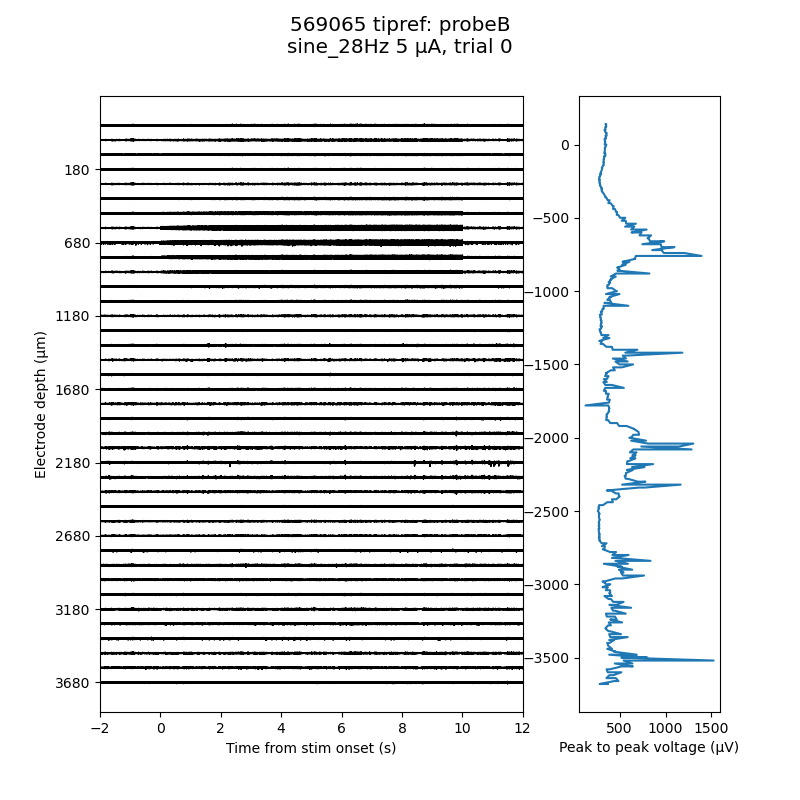

In [30]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[3, 1], wspace=0.2)

apax = fig.add_subplot(gs[0])
sep = 2000
for chind in range(plot_traces.shape[1]):
    apax.plot(time_axis, plot_traces[:, chind] + chind * sep, 'k', linewidth=1)
apax.set_xlim(plot_win)
apax.set_xlabel('Time from stim onset (s)')
apax.set_ylabel('Electrode depth (\u03bcm)')

plt.yticks(range(0, chind*sep+200, sep)[::5], probe_unit_data[plot_probe]['ch_depths'][plot_chs][::5]);

ppax = fig.add_subplot(gs[1])
ppax.plot(peak_to_peak, -probe_unit_data[plot_probe]['ch_depths'])
ppax.set_xlabel('Peak to peak voltage (\u03bcV)')

plt.suptitle('{} {}: {}\n{} {:d} \u03bcA, trial {:d}'.format(exp.mouse, exp_tag, plot_probe, stim_type, stim_amp, which_event))

### SAVE ###
figname = '{}_{}_amp_across_chs_{}{:d}.png'.format(exp_tag, plot_probe, stim_type, stim_amp)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=True)